In [ ]:
import docx
from simplify_docx import simplify
from os import listdir
from os.path import isfile
import pathlib
import json
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import xml.etree.ElementTree as ET
import xmltodict
import json
from xml.dom import minidom
from collections import OrderedDict

###### This script Converts all xml files (initially docx was converted to xml) under the ./annotation/ directory and outputs to one json file (train.json) in current directory.

In [ ]:


def XML2JSON(xmlFiles):
    attrDict = dict()
    attrDict["categories"]=[{"supercategory":"none","id":1,"name":"Grape"}]
    images = list()
    annotations = list()
    image_id = 0
    for file in xmlFiles:    
        image_id = image_id + 1      
        annotation_path=file
        image = dict()
        doc = xmltodict.parse(open(annotation_path).read(), force_list=('object'))
        print(doc)
        image['file_name'] = str(doc['annotations']['filename'])
        image['height'] = int(doc['annotations']['size']['height'])
        image['width'] = int(doc['annotations']['size']['width'])
        image['id'] = image_id
        print ("File Name: {} and image_id {}".format(file, image_id))
        images.append(image)
        id1 = 1
        if 'object' in doc['annotations']:
            for obj in doc['annotations']['object']:
                for value in attrDict["categories"]:
                    annotation = dict()          
                    if str(obj['name']) == value["name"]:
                        annotation["iscrowd"] = 0
                        annotation["image_id"] = image_id
                        x1 = (float(obj["bndbox"]["xmin"]))  - 1
                        y1 = (float(obj["bndbox"]["ymin"])) - 1
                        x2 = (float(obj["bndbox"]["xmax"])) - x1
                        y2 = (float(obj["bndbox"]["ymax"])) - y1                         
                        annotation["bbox"] = [x1, y1, x2, y2]
                        annotation["area"] = float(x2 * y2)
                        annotation["category_id"] = value["id"]
                        annotation["ignore"] = 0
                        annotation["id"] = id1
                        annotation["segmentation"] = [[x1,y1,x1,(y1 + y2), (x1 + x2), (y1 + y2), (x1 + x2), y1]]
                        id1 +=1
                        annotations.append(annotation)

            else:
                print("File: {} doesn't have any object".format(file))

        else:
            print("File: {} not found".format(file))
            

    attrDict["images"] = images    
    attrDict["annotations"] = annotations
    attrDict["type"] = "instances"

    jsonString = json.dumps(attrDict)
    with open("train.json", "w") as f:
        f.write(jsonString)


path=r"..\annotation\\"                                 ## Path of the folder having all the annotations in XML format
trainXMLFiles=glob.glob(os.path.join(path, '*.xml'))
XML2JSON(trainXMLFiles)


In [ ]:
with open(r'..\train.json') as f:                                            ## Give path of the train.json saved
    data = json.loads(f.read())                                              ## Reading the json file


In [ ]:
# Viewing  keys in our converted data( From XML to Json)
data.keys()

dict_keys(['categories', 'images', 'annotations', 'type'])

In [ ]:
#Example of Viewing the value's in categories key
print(np.unique(data['categories']))

[{'supercategory': 'none', 'id': 1, 'name': 'Grape'}]


In [ ]:
#Example of Viewing the value's in annotations key
print(data['annotations'][0])

{'iscrowd': 0, 'image_id': 1, 'bbox': [358.5104, 652.3568, 439.048, 785.8575999999998], 'area': 345029.20756479993, 'category_id': 1, 'ignore': 0, 'id': 1, 'segmentation': [[358.5104, 652.3568, 358.5104, 1438.2143999999998, 797.5584, 1438.2143999999998, 797.5584, 652.3568]]}


In [ ]:
#Example of Viewing the value's in type key
data['type']

'instances'

In [ ]:
#Example of the value's in image key
print(data['images'][0])

{'file_name': 'CDY_2015.jpg', 'height': 3456, 'width': 5184, 'id': 1}


###### Finding number of images, Annotation and Category in our Data

In [ ]:
n_images = len(data['images'])
n_boxes = len(data['annotations'])
n_categ = len(data['categories'])

# height, width
heights = [x['height'] for x in data['images']]
widths = [x['width'] for x in data['images']]

print('Number of Images: ' + str(n_images))
print('Total number of annotations: ' + str(n_boxes))
print('Number of Category of annotations: ' + str(n_categ))

Number of Images: 300
Total number of annotations: 4431
Number of Category of annotations: 1


###### Analysing Annotations in out training images

In [ ]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in data['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

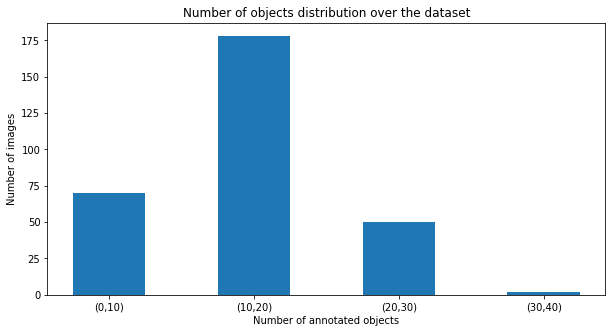

Number of images having atleast one box:  300
Min number of boxes per image:  2
Max number of boxes per image:  34
Avg number of boxes per image:  14


In [ ]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of annotated objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

###### Number of Classes and its annotation distribution

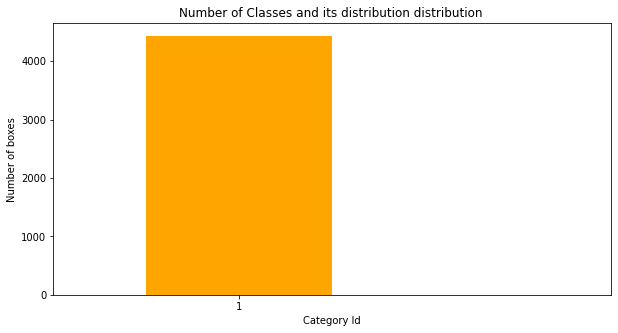

In [ ]:
# Class distribution
class2nboxes = {} 

for ann in data['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Number of Classes and its distribution distribution ')
plt.show()


###### Class wise bounding box area distribution

In [ ]:


bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in data['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

1 -> Grape, 

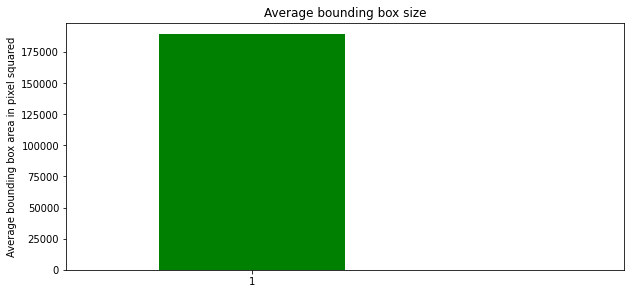

In [ ]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]



plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Average bounding box size')


categ_map = {x['id']: x['name'] for x in data['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

###### Analysing the dimensions of Images in our Dataset

In [ ]:
p = pd.DataFrame({'Height':[i['height'] for i in data['images']],'Width':[i['width'] for i in data['images']]})

In [ ]:
print('Mean hight of images: ' + str(np.mean(p['Height'])))
print('Max height of Image: '+ str(np.max(p['Height'])))
print('Min height of Images: '+ str(np.min(p['Height'])))
print('Mean width of images: ' + str(np.mean(p['Width'])))
print('Max width of Image: '+ str(np.max(p['Width'])))
print('Min width of Images: '+ str(np.min(p['Width'])))

Mean hight of images: 2954.88
Max height of Image: 3456
Min height of Images: 864
Mean width of images: 4331.52
Max width of Image: 5184
Min width of Images: 1296


##### Sample Image

uint8


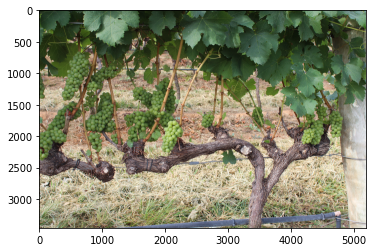

In [ ]:
import skimage
import skimage.io

test_img_f = r'..\CDY_2015.jpg'                                         ##Path of one of hte images from dataset
im = skimage.io.imread(test_img_f)

#skimage.io.imshow(im)
print(im.dtype)
plt.imshow(im)
plt.show() 

Plotted the Images in RGB and also Color Channels Histogram

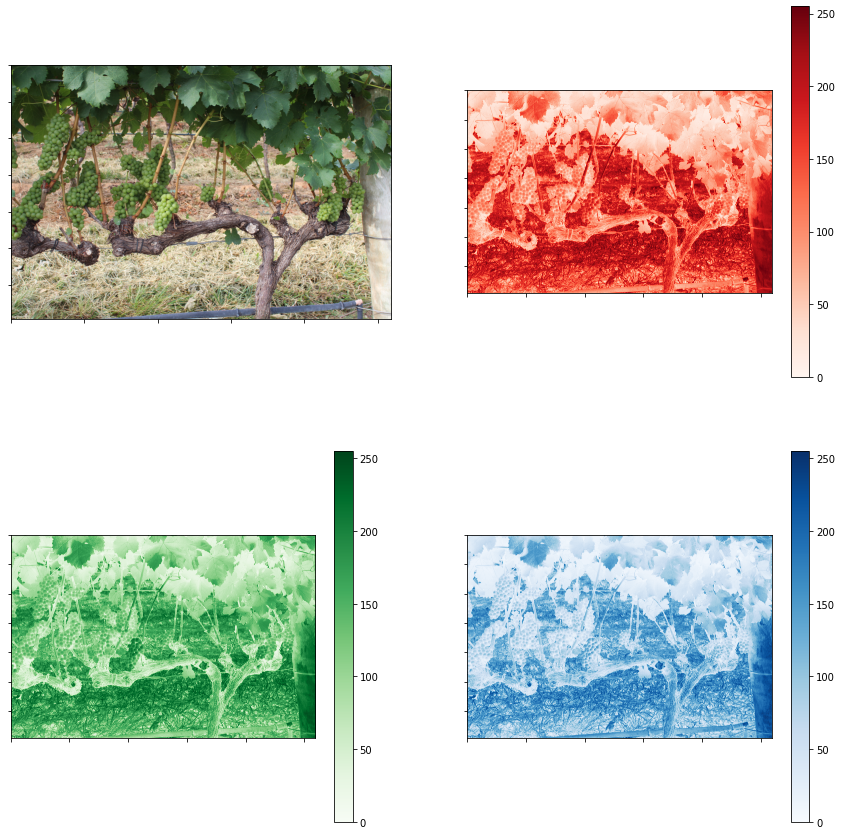

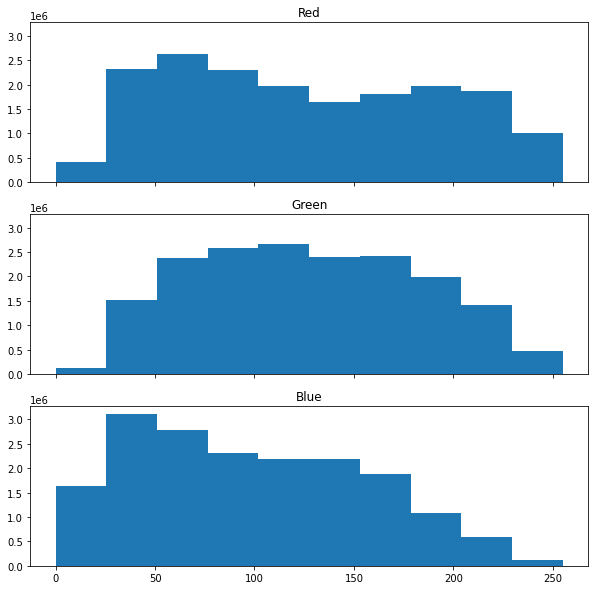

In [ ]:
# Split
red = im[:, :, 0]
green = im[:, :, 1]
blue = im[:, :, 2]


# Plot
fig, axs = plt.subplots(2,2,figsize=(15, 15))

cax_00 = axs[0,0].imshow(im)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

# Plot RGB Channels histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(10, 10))

axs[0].hist(red.ravel(), bins=10)
axs[0].set_title('Red')
axs[1].hist(green.ravel(), bins=10)
axs[1].set_title('Green')
axs[2].hist(blue.ravel(), bins=10)
axs[2].set_title('Blue')

plt.show()
